# 2) IACOV - Model Development for Prognosis - DEATH
## Strategy 5) Training on all other hospitals plus 70% of a specific hospital. Test on 30% of the specific hospital

Code below to import libraries when running this point forward

In [96]:
# !pip install npm nodejs

In [97]:
# !jupyter lab clean
# !jupyter lab build

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# para evitarmos a exibição dos dados em notacao científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#comment next line to not use MLFlow for cleaning data
from MLFlow_Classification import *
from MLFlow_Utils import *

In [4]:
#Put csv in same folder as this notebook
dataset = pd.read_csv("df_iacov_en.csv", delimiter=";")
df_iacov_model = pd.DataFrame(dataset)
df_iacov_model.shape

(8494, 65)

In [5]:
df_iacov_model.columns

Index(['city_hospital', 'cd_patient', 'hospital_time', 'age', 'race', 'braden',
       'heart_rate', 'resp_rate', 'sys_press', 'dias_press', 'mean_press',
       'temp', 'saturation', 'weight', 'height', 'hemoglobin', 'platelets',
       'hematocrit', 'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes',
       'neutrophil', 'lymphocytes', 'neutr_lymph_ratio', 'lymph_crp_ratio',
       'basophils', 'eosinophils', 'monocytes', 'crp', 'albumin', 'ldh', 'alt',
       'ast', 'total_bilirubin', 'direct_bilirubin', 'indirect_bilirubin',
       'urea', 'sodium', 'potassium', 'creatinine', 'troponin', 'd_dimer',
       'venous_lactate', 'cpk', 'inr', 'aptt', 'arterial_lactate', 'gas_ph',
       'gaso_po2', 'gas_paco2', 'gas_hco3', 'gas_be', 'gas_so2', 'magnesium',
       'calcium_ionised', 'total_calcium', 'glucose', 'state', 'region', 'icu',
       'death', 'mv', 'male'],
      dtype='object')

In [7]:
df_iacov_model.iloc[:,2:65].head(5)

,hospital_time,age,race,braden,heart_rate,resp_rate,sys_press,dias_press,mean_press,temp,...,magnesium,calcium_ionised,total_calcium,glucose,state,region,icu,death,mv,male
0,10.000,56.000,Pardo,nan,89.000,23.000,130.000,80.000,96.650,36.500,...,nan,nan,nan,nan,AM,NORTE,1,0,1,1.000
1,10.000,61.000,Pardo,nan,86.000,18.000,172.000,75.000,107.301,34.800,...,2.100,1.150,nan,nan,AM,NORTE,1,1,1,1.000
2,79.000,28.000,Pardo,nan,80.000,30.000,117.000,56.000,76.313,37.400,...,2.500,1.210,7.280,nan,AM,NORTE,1,0,1,1.000
3,15.000,69.000,Pardo,nan,68.000,nan,149.000,81.000,103.644,37.300,...,nan,nan,nan,nan,AM,NORTE,0,0,0,0.000
4,16.000,66.000,Pardo,nan,67.000,nan,124.000,75.000,91.317,36.600,...,2.100,nan,7.770,nan,AM,NORTE,1,0,1,1.000


## 2.1) Assign binary outcome to be predicted

### 2.1.1) Maintain essential variables (LEAN Model)

In [8]:
#22 predictors + outcome
df_iacov_model_lean = df_iacov_model[['city_hospital'
                                      ,'age'
                                      ,'male'
                                      ,'heart_rate'
                                      ,'resp_rate'
                                      ,'sys_press'
                                      ,'dias_press'
                                      ,'mean_press'
                                      ,'temp'
                                      ,'hemoglobin'
                                      ,'platelets'
                                      ,'hematocrit'
                                      ,'red_cells_count'
                                      ,'hcm'
                                      ,'rdw'
                                      ,'mcv'
                                      ,'leukocytes'
                                      ,'neutrophil'
                                      ,'lymphocytes'
                                      ,'basophils'
                                      ,'eosinophils'
                                      ,'monocytes'
                                      ,'crp'
                                      ,'death'
                                      ,'region' #for filtering purposes
                                      ,'state' #for filtering purposes
                                     ]]
df_iacov_model_lean.shape

(8494, 26)

In [9]:
df_iacov_model_lean.to_csv('df_iacov_model_lean.csv', sep=';', index=False)

### 2.1.2) Filter a specific hospital

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# para evitarmos a exibição dos dados em notacao científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#comment next line to not use MLFlow for cleaning data
from MLFlow_Classification import *
from MLFlow_Utils import *

In [11]:
#Put csv in same folder as this notebook
df_all_hospitals = pd.read_csv("df_iacov_model_lean.csv", delimiter=";", decimal=".")
df_all_hospitals.shape

(8494, 26)

In [12]:
df_all_hospitals.columns

Index(['city_hospital', 'age', 'male', 'heart_rate', 'resp_rate', 'sys_press',
       'dias_press', 'mean_press', 'temp', 'hemoglobin', 'platelets',
       'hematocrit', 'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes',
       'neutrophil', 'lymphocytes', 'basophils', 'eosinophils', 'monocytes',
       'crp', 'death', 'region', 'state'],
      dtype='object')

In [13]:
df_all_hospitals.region.value_counts()

SUDESTE        4201
NORDESTE       2389
CENTROOESTE     898
SUL             712
NORTE           294
Name: region, dtype: int64

In [14]:
column_summaries(df_all_hospitals)

,Missing Values,% missing of Total Values,# Unique Values,# Values as [0],datatype,skew,count,mean,std,min,25%,50%,75%,max
city_hospital,0,0.000,19,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan
age,0,0.000,98,0,float64,-0.114,8494.000,58.385,17.287,18.000,45.000,59.000,71.000,105.000
male,1,0.012,2,3814,float64,-0.205,8493.000,0.551,0.497,0.000,0.000,1.000,1.000,1.000
heart_rate,2654,31.246,184,0,float64,0.609,5840.000,86.017,17.388,13.000,75.000,85.000,96.000,233.000
resp_rate,3368,39.652,74,1,float64,6.066,5126.000,21.989,7.064,0.000,18.000,20.000,24.000,202.000
sys_press,3211,37.803,220,0,float64,70.917,5283.000,126.629,179.854,10.000,110.000,122.000,138.000,13090.000
dias_press,3202,37.697,155,0,float64,17.255,5292.000,74.777,18.972,6.000,67.000,76.000,81.000,931.000
mean_press,3644,42.901,1456,326,float64,-1.719,4850.000,83.867,28.192,0.000,78.977,90.000,98.500,235.000
temp,3115,36.673,129,1,float64,65.829,5379.000,36.438,4.744,0.000,36.000,36.300,36.800,372.000
hemoglobin,1984,23.358,250,0,float64,17.184,6510.000,12.766,3.096,1.400,11.500,13.000,14.300,133.000


In [15]:
import ipywidgets as widgets
from IPython.display import clear_output

Code omitted due to confidentiality

In [19]:
specific_hospital = 'Choose a hospital'
df_iacov_model_lean = df_all_hospitals

def dropdown_hospital_eventhandler(change):
    global specific_hospital 
    specific_hospital = change.new
    dropdown_hospital.observe(dropdown_hospital_eventhandler, names='value')

In [20]:
dropdown_hospital.observe(dropdown_hospital_eventhandler, names='value')

**Select Hospital to train**

In [21]:
# !pip install ipywidgets

In [22]:
# !jupyter nbextension enable --py widgetsnbextension

In [23]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [25]:
# display(dropdown_hospital)

**Filter all hospitals except the selected above**

In [26]:
df_all_hospitals.region.value_counts()

SUDESTE        4201
NORDESTE       2389
CENTROOESTE     898
SUL             712
NORTE           294
Name: region, dtype: int64

**Split train/test of specific Hospital**

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
#Filter the specific hospital
df_iacov_model_lean_specific = df_all_hospitals[df_all_hospitals.city_hospital == specific_hospital]
df_iacov_model_lean_specific.shape

(1776, 26)

In [29]:
X_specific = df_iacov_model_lean_specific.drop(['death'],axis=1)
X_specific.shape

(1776, 25)

In [30]:
y_specific = df_iacov_model_lean_specific['death']
y_specific.shape

(1776,)

In [31]:
X_train_specific, X_test_specific, y_train_specific, y_test_specific = train_test_split(X_specific, y_specific, test_size=0.30, random_state=42, stratify=y_specific)

In [32]:
X_train_specific.shape

(1243, 25)

In [33]:
X_test_specific.shape

(533, 25)

**Filter all hospitals + 70% of specific hospital for TRAINING**

In [34]:
#Also removed hospital with few observations
df_iacov_model_lean = df_all_hospitals[ (~df_all_hospitals.index.isin(X_test_specific.index)) & (df_all_hospitals.city_hospital != 'OMITTED')]
df_iacov_model_lean.shape

(7944, 26)

In [37]:
# print("Specific: " + specific_hospital )
print("(training - all hospitals) dataset: " + str(df_iacov_model_lean.shape))

print("\n(training - specific) dataset: {}".format(X_train_specific.shape))

print("\n(test - specific) dataset: {}".format(X_test_specific.shape))

(training - all hospitals) dataset: (7944, 26)

(training - specific) dataset: (1243, 25)

(test - specific) dataset: (533, 25)


### 2.1.3) Dropping unused variables (All hospitals)

In [38]:
df_iacov_model_lean = df_iacov_model_lean.drop(['city_hospital'],axis=1)
df_iacov_model_lean.shape

(7944, 25)

In [39]:
#Preencho NAs com 0 
df_iacov_model_lean['death'] = df_iacov_model_lean['death'].fillna(0)
df_iacov_model_lean.death.value_counts()

0    5809
1    2135
Name: death, dtype: int64

In [40]:
(df_iacov_model_lean.death.value_counts()/len(df_iacov_model_lean.death))*100

0   73.124
1   26.876
Name: death, dtype: float64

**Set class**

In [41]:
df_iacov_model_lean['class'] = df_iacov_model_lean['death'].astype('int')
df_iacov_model_lean = df_iacov_model_lean.drop(['death'],axis=1)
df_iacov_model_lean.head()

,age,male,heart_rate,resp_rate,sys_press,dias_press,mean_press,temp,hemoglobin,platelets,...,leukocytes,neutrophil,lymphocytes,basophils,eosinophils,monocytes,crp,region,state,class
0,56.000,1.000,89.000,23.000,130.000,80.000,96.650,36.500,3.200,251000.000,...,16110.000,13166.000,1271.000,42.000,39.000,1592.000,nan,NORTE,AM,0
1,61.000,1.000,86.000,18.000,172.000,75.000,107.301,34.800,11.600,110900.000,...,12710.000,12201.000,381.000,0.000,0.000,127.000,15.100,NORTE,AM,1
2,28.000,1.000,80.000,30.000,117.000,56.000,76.313,37.400,6.400,237000.000,...,11400.000,9784.000,776.000,63.000,126.000,651.000,200.400,NORTE,AM,0
3,69.000,0.000,68.000,nan,149.000,81.000,103.644,37.300,12.400,223900.000,...,6400.000,4339.000,930.000,117.000,318.000,696.000,13.400,NORTE,AM,0
4,66.000,1.000,67.000,nan,124.000,75.000,91.317,36.600,13.500,242600.000,...,4393.000,2874.000,562.000,50.000,245.000,662.000,26.800,NORTE,AM,0


### 2.1.4) Recalculating null mean_press

In [42]:
def isNullMeanPressure(row):

    if pd.isnull(row['mean_press']):
    
        if pd.notnull(row['sys_press']) and pd.notnull(row['dias_press']):
            return (row['sys_press']+row['dias_press'])/2
        else:
            return row['mean_press']
    else:
        return row['mean_press']

In [43]:
#Check mean_press missing before recalculating
column_summaries(df_iacov_model_lean)

,Missing Values,% missing of Total Values,# Unique Values,# Values as [0],datatype,skew,count,mean,std,min,25%,50%,75%,max
age,0,0.000,98,0,float64,-0.114,7944.000,58.349,17.392,18.000,45.000,59.000,72.000,105.000
male,1,0.013,2,3582,float64,-0.197,7943.000,0.549,0.498,0.000,0.000,1.000,1.000,1.000
heart_rate,2121,26.699,184,0,float64,0.609,5823.000,85.992,17.371,13.000,75.000,85.000,96.000,233.000
resp_rate,2835,35.687,74,1,float64,6.062,5109.000,21.992,7.073,0.000,18.000,20.000,24.000,202.000
sys_press,2677,33.698,219,0,float64,70.818,5267.000,126.632,180.121,10.000,110.000,122.000,138.000,13090.000
dias_press,2668,33.585,155,0,float64,17.292,5276.000,74.775,18.976,6.000,67.000,76.000,81.000,931.000
mean_press,3094,38.948,1456,326,float64,-1.719,4850.000,83.867,28.192,0.000,78.977,90.000,98.500,235.000
temp,2580,32.477,129,1,float64,65.750,5364.000,36.438,4.750,0.000,36.000,36.300,36.800,372.000
hemoglobin,1965,24.736,246,0,float64,17.974,5979.000,12.780,3.139,1.400,11.600,13.000,14.300,133.000
platelets,805,10.133,1102,0,float64,0.432,7139.000,225408.420,140156.461,5.000,142000.000,210000.000,304000.000,992000.000


In [44]:
df_iacov_model_lean['mean_press'] = df_iacov_model_lean.apply(isNullMeanPressure, axis=1)

In [45]:
#Check mean_press missing after recalculating
column_summaries(df_iacov_model_lean)

,Missing Values,% missing of Total Values,# Unique Values,# Values as [0],datatype,skew,count,mean,std,min,25%,50%,75%,max
age,0,0.000,98,0,float64,-0.114,7944.000,58.349,17.392,18.000,45.000,59.000,72.000,105.000
male,1,0.013,2,3582,float64,-0.197,7943.000,0.549,0.498,0.000,0.000,1.000,1.000,1.000
heart_rate,2121,26.699,184,0,float64,0.609,5823.000,85.992,17.371,13.000,75.000,85.000,96.000,233.000
resp_rate,2835,35.687,74,1,float64,6.062,5109.000,21.992,7.073,0.000,18.000,20.000,24.000,202.000
sys_press,2677,33.698,219,0,float64,70.818,5267.000,126.632,180.121,10.000,110.000,122.000,138.000,13090.000
dias_press,2668,33.585,155,0,float64,17.292,5276.000,74.775,18.976,6.000,67.000,76.000,81.000,931.000
mean_press,2340,29.456,1493,326,float64,-1.700,5604.000,86.242,27.613,0.000,80.000,91.312,100.000,235.000
temp,2580,32.477,129,1,float64,65.750,5364.000,36.438,4.750,0.000,36.000,36.300,36.800,372.000
hemoglobin,1965,24.736,246,0,float64,17.974,5979.000,12.780,3.139,1.400,11.600,13.000,14.300,133.000
platelets,805,10.133,1102,0,float64,0.432,7139.000,225408.420,140156.461,5.000,142000.000,210000.000,304000.000,992000.000


In [46]:
X_test_specific['mean_press'] = X_test_specific.apply(isNullMeanPressure, axis=1)

In [47]:
column_summaries(X_test_specific)

,Missing Values,% missing of Total Values,# Unique Values,# Values as [0],datatype,skew,count,mean,std,min,25%,50%,75%,max
city_hospital,0,0.000,1,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan
age,0,0.000,75,0,float64,-0.091,533.000,58.878,15.536,20.000,48.000,60.000,70.000,99.000
male,0,0.000,2,222,float64,-0.340,533.000,0.583,0.493,0.000,0.000,1.000,1.000,1.000
heart_rate,533,100.000,0,0,float64,nan,0.000,nan,nan,nan,nan,nan,nan,nan
resp_rate,533,100.000,0,0,float64,nan,0.000,nan,nan,nan,nan,nan,nan,nan
sys_press,533,100.000,0,0,float64,nan,0.000,nan,nan,nan,nan,nan,nan,nan
dias_press,533,100.000,0,0,float64,nan,0.000,nan,nan,nan,nan,nan,nan,nan
mean_press,533,100.000,0,0,float64,nan,0.000,nan,nan,nan,nan,nan,nan,nan
temp,533,100.000,0,0,float64,nan,0.000,nan,nan,nan,nan,nan,nan,nan
hemoglobin,19,3.565,112,0,float64,-0.721,514.000,12.626,2.560,3.300,11.400,13.000,14.400,18.700


In [48]:
x_test_specific_name = 'X_test_all_plus_specific_' + X_test_specific.region.iloc[0]  \
                        + '_' + X_test_specific.state.iloc[0]  \
                        + '_' + X_test_specific.city_hospital.iloc[0] +  ".csv"
# x_test_specific_name

In [49]:
y_test_specific_name = 'y_death_all_plus_specific_' + X_test_specific.region.iloc[0]  \
                        + '_' + X_test_specific.state.iloc[0]  \
                        + '_' + X_test_specific.city_hospital.iloc[0] +  ".csv"
# y_test_specific_name

In [50]:
X_test_specific.to_csv(x_test_specific_name, sep=';')
X_test_specific.shape

(533, 25)

In [51]:
y_test_specific.to_csv(y_test_specific_name, sep=';')
y_test_specific.shape

(533,)

## 2.4) Prepare Experiment 

### All hospitals plus 70% of specific

In [52]:
df_iacov_model_lean.shape

(7944, 25)

In [53]:
df_iacov_model_train = df_iacov_model_lean

In [54]:
df_iacov_model_train = df_iacov_model_train.drop(['region'],axis=1)
df_iacov_model_train = df_iacov_model_train.drop(['state'],axis=1)
df_iacov_model_train.columns

Index(['age', 'male', 'heart_rate', 'resp_rate', 'sys_press', 'dias_press',
       'mean_press', 'temp', 'hemoglobin', 'platelets', 'hematocrit',
       'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes', 'neutrophil',
       'lymphocytes', 'basophils', 'eosinophils', 'monocytes', 'crp', 'class'],
      dtype='object')

In [55]:
df_iacov_model_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7944 entries, 0 to 8476
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              7944 non-null   float64
 1   male             7943 non-null   float64
 2   heart_rate       5823 non-null   float64
 3   resp_rate        5109 non-null   float64
 4   sys_press        5267 non-null   float64
 5   dias_press       5276 non-null   float64
 6   mean_press       5604 non-null   float64
 7   temp             5364 non-null   float64
 8   hemoglobin       5979 non-null   float64
 9   platelets        7139 non-null   float64
 10  hematocrit       5529 non-null   float64
 11  red_cells_count  5004 non-null   float64
 12  hcm              6688 non-null   float64
 13  rdw              6691 non-null   float64
 14  mcv              6694 non-null   float64
 15  leukocytes       7139 non-null   float64
 16  neutrophil       5311 non-null   float64
 17  lymphocytes   

In [56]:
exp = setup(df_iacov_model_train
            , target='class'
            , categorical_features = ['male']
            , numeric_features = ['crp','basophils','eosinophils','red_cells_count','monocytes','hemoglobin','resp_rate','neutrophil','hematocrit']
            , normalize=True
            #, remove_multicollinearity=True
            ,numeric_imputation='median'
#             ,numeric_imputation='ignore'
            #,multicollinearity_threshold=0.9
            , resample=True
            , resample_method='random_over'
#             , train_size = 1.0 #100pct for training
           )

 
Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(7944, 23)"
4,Missing Values,True
5,Numeric Features,21
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [57]:
X, y, X_train, X_test, y_train, y_test, seed, prep_pipe, _ = exp

In [58]:
X_train.shape

(8132, 23)

In [59]:
X_test.shape

(2384, 23)

In [60]:
X_test.head()

,age,heart_rate,resp_rate,sys_press,dias_press,mean_press,temp,hemoglobin,platelets,hematocrit,...,mcv,leukocytes,neutrophil,lymphocytes,basophils,eosinophils,monocytes,crp,male_0.0,male_nan
4484,-0.710,-0.049,-0.223,-0.021,0.053,0.153,-0.024,0.024,1.649,-0.190,...,-0.660,-0.511,0.389,0.160,-0.291,-0.148,1.297,-0.259,0.000,0.000
3146,-1.803,-0.049,-0.223,-0.021,0.053,0.153,-0.024,0.061,-0.104,0.100,...,0.010,-0.081,-0.161,-0.038,-0.291,-0.148,-0.100,-0.230,1.000,0.000
977,1.417,0.959,-0.223,0.238,2.896,2.243,-0.024,0.134,-1.681,-0.009,...,-2.629,-0.638,-1.546,-0.272,-0.291,-0.153,-0.896,0.682,0.000,0.000
6997,-1.630,-0.049,-0.223,-0.021,0.053,0.153,-0.024,-0.563,-0.360,-0.826,...,-1.592,0.082,-0.161,-0.250,-0.291,-0.148,-0.693,-0.230,0.000,0.000
2087,1.302,-0.788,1.864,-0.021,-0.981,-0.304,-0.229,0.061,0.445,0.100,...,-0.735,0.533,1.847,-0.200,-0.291,-0.148,-0.897,-0.284,1.000,0.000


In [61]:
seed

42

In [62]:
# Xtrain.head()

### Filtering only 5 pre-selected models

In [63]:
# print(inspect.getsource(compare_models))

In [64]:
#Modelos que suportam missing (1) - Modelos pre-selecionados(2)
# compare_models(blacklist = ["lr","knn","nb","dt","svm","rbfsvm","gpc","mlp","ridge","qda","ada","gbc","lda", "rf" ,"et"] , turbo = False)
# compare_models(blacklist = ["lr","knn","nb","dt","svm","rbfsvm","gpc","ridge","qda","ada","gbc","lda","lightgbm"] , turbo = False)
compare_models(blacklist = ["lr","knn","nb","dt","svm","rbfsvm","gpc","ridge","qda","ada","gbc","lda","et","mlp","rf"] , turbo = False)

,Model,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,Extreme Gradient Boosting,0.898600,0.959600,0.960900,0.836200,0.854500,0.904200,0.797100,0.004900,0.381200,0.691000
1,Light Gradient Boosting Machine,0.872100,0.942800,0.930900,0.813300,0.833100,0.879000,0.744200,0.057900,0.003600,0.618800
2,CatBoost Classifier,0.860100,0.936400,0.909500,0.810600,0.827700,0.866500,0.720100,0.042200,0.002900,0.594400


### Tune selected models by AUC (and hyperopt bayesian optimization) to use on test data

In [65]:
cattuned = tune_model('catboost', optimize='AUC', n_iter=20)

,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,0.887,0.962,0.914,0.860,0.867,0.890,0.774,0.000,0.780,0.684
1,0.902,0.971,0.916,0.887,0.890,0.903,0.803,0.001,0.060,0.726
2,0.879,0.970,0.899,0.860,0.865,0.882,0.759,0.000,0.962,0.704
3,0.893,0.967,0.914,0.872,0.877,0.895,0.786,0.000,0.800,0.698
4,0.935,0.997,1.000,0.870,0.884,0.939,0.870,0.000,0.009,0.795
5,0.936,0.996,1.000,0.872,0.886,0.940,0.872,0.000,0.012,0.814
6,0.927,0.998,0.995,0.860,0.877,0.932,0.855,0.000,0.153,0.801
7,0.927,0.997,0.998,0.857,0.875,0.932,0.855,0.000,0.019,0.796
8,0.925,0.996,0.995,0.855,0.873,0.930,0.850,0.000,0.072,0.784
9,0.922,0.998,0.998,0.847,0.868,0.928,0.845,0.000,0.059,0.795


In [66]:
# cattuned.feature_names_

In [67]:
lgbmtuned = tune_model('lightgbm', optimize='AUC', n_iter=20)

,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,0.889,0.957,0.939,0.840,0.855,0.895,0.779,0.000,0.000,0.627
1,0.899,0.973,0.936,0.862,0.872,0.903,0.798,0.000,0.000,0.682
2,0.886,0.969,0.931,0.840,0.853,0.890,0.771,0.000,0.000,0.642
3,0.886,0.975,0.948,0.823,0.843,0.892,0.771,0.000,0.000,0.637
4,0.914,0.992,1.000,0.828,0.853,0.921,0.828,0.000,0.000,0.727
5,0.908,0.992,1.000,0.816,0.844,0.915,0.816,0.000,0.000,0.710
6,0.910,0.997,1.000,0.820,0.848,0.918,0.820,0.000,0.000,0.713
7,0.918,0.995,1.000,0.835,0.859,0.924,0.835,0.000,0.000,0.742
8,0.900,0.990,1.000,0.800,0.834,0.909,0.801,0.000,0.000,0.679
9,0.897,0.999,1.000,0.793,0.829,0.906,0.793,0.000,0.000,0.694


In [68]:
xgbtuned = tune_model('xgboost', optimize='AUC', n_iter=20)

,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,0.878,0.941,0.946,0.811,0.833,0.886,0.757,0.000,0.000,0.622
1,0.889,0.964,0.946,0.833,0.850,0.895,0.779,0.000,0.009,0.668
2,0.875,0.951,0.948,0.801,0.826,0.883,0.749,0.000,0.000,0.614
3,0.871,0.952,0.953,0.789,0.818,0.880,0.742,0.000,0.000,0.612
4,0.900,0.978,1.000,0.801,0.834,0.909,0.801,0.000,0.009,0.686
5,0.899,0.972,1.000,0.798,0.832,0.908,0.798,0.000,0.001,0.705
6,0.894,0.978,1.000,0.788,0.826,0.904,0.788,0.000,0.000,0.688
7,0.895,0.975,0.998,0.793,0.829,0.905,0.791,0.000,0.000,0.686
8,0.877,0.971,1.000,0.754,0.803,0.891,0.754,0.000,0.000,0.647
9,0.898,0.980,1.000,0.796,0.831,0.907,0.796,0.000,0.000,0.691


### Select best algorithm based on test data AUC

In [69]:
preds = predict_model(cattuned)

,Model,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,CatBoost Classifier,0.781,0.835,0.543,0.869,0.603,0.571,0.425,0.000,0.000,0.250


In [70]:
preds = predict_model(lgbmtuned)

,Model,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,Light Gradient Boosting Machine,0.786,0.846,0.635,0.842,0.596,0.615,0.467,0.000,0.000,0.142


In [71]:
preds = predict_model(xgbtuned)

,Model,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,Extreme Gradient Boosting,0.781,0.843,0.725,0.802,0.574,0.641,0.487,0.000,0.000,0.181


### Best model

In [72]:
preds = predict_model(lgbmtuned)

,Model,Accuracy,AUC,Recall,Specificity,Prec.,F1,Kappa,Hosmer_lemeshow,Spiegelhalter,Scaled_brier
0,Light Gradient Boosting Machine,0.786,0.846,0.635,0.842,0.596,0.615,0.467,0.000,0.000,0.142


In [73]:
npv(y_test, preds['Label'])

0.8624338624338624

In [74]:
#ROC AUC (INTERVALO)
["{0:0.2f}".format(i) for i in AUC_CI(y_test, preds['Score'])]

['0.83', '0.86']

,,
,,
Ground Truth Prevalence,. . .,0.269
Test set Prevalence,. . .,0.286
True positive rate (recall),. . .,0.635
False positive rate,. . .,0.158
Positive predictive value (precision),. . .,0.596
True negative rate (specificity),. . .,0.842
False negative rate,. . .,0.365
Negative predictive value,. . .,0.862
Positive likelihood ratio (bigger is better),. . .,4.010


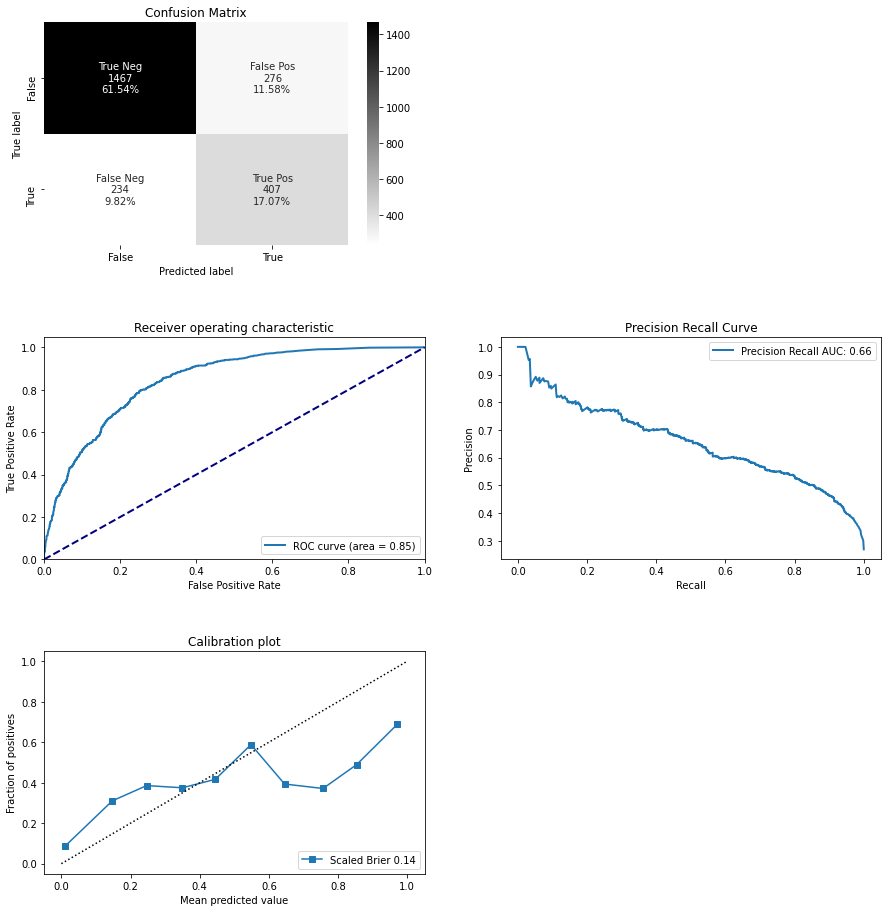

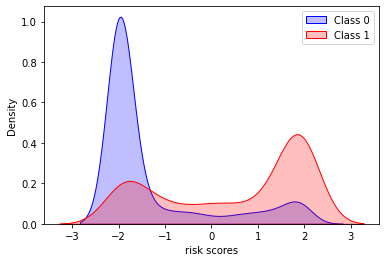

,,
,,
Ground Truth Prevalence,. . .,0.269
Test set Prevalence,. . .,0.286
True positive rate (recall),. . .,0.635
False positive rate,. . .,0.158
Positive predictive value (precision),. . .,0.596
True negative rate (specificity),. . .,0.842
False negative rate,. . .,0.365
Negative predictive value,. . .,0.862
Positive likelihood ratio (bigger is better),. . .,4.010


In [75]:
import MLFlow_Utils
binary_classification_metrics(y_test, preds["Label"], preds["Score"])

### Understand best algorithm features and results

In [77]:
# evaluate_model(lgbmtuned)

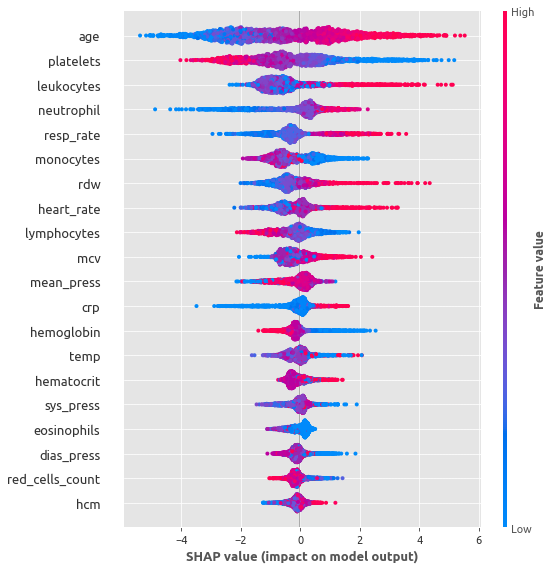

In [78]:
interpret_model(lgbmtuned)

In [79]:
plot_model(lgbmtuned, plot='ktops')

IntProgress(value=0, description='Processing: ', max=5)

Using 20% rows of the test set (n = 476)


,prob,predicted_class,real,result
2130,1.000,1,1,1
1957,1.000,1,1,1
1649,1.000,1,1,1
2197,1.000,1,1,1
1431,1.000,1,1,1
...,...,...,...,...
2157,0.835,1,1,1
832,0.834,1,1,1
1015,0.829,1,1,1
464,0.828,1,1,1


Positive rows in the test set= 641
True positive predictions in the 20% k-tops =  316
% of accuracy = 49.297971918876755%


In [80]:
# cattuned

### 2.3.1) Build a model with all data

In [81]:
final_model = finalize_model(lgbmtuned)

In [82]:
str(final_model.__class__.__name__)

'LGBMClassifier'

In [84]:
final_model_name = str(final_model.__class__.__name__) + '_all_regions_plus_70pct_one_' \
                    + X_test_specific.region.iloc[0]  \
                    + '_' + X_test_specific.state.iloc[0]  \
                    + '_' + X_test_specific.city_hospital.iloc[0]
# final_model_name

In [85]:
save_model(final_model, final_model_name ,verbose=True)

Transformation Pipeline and Model Succesfully Saved


In [86]:
final_model

LGBMClassifier(colsample_bytree=0.8549345912607054, n_estimators=1200,
               num_leaves=101, random_state=42, reg_alpha=0.25040322158625117,
               reg_lambda=0.08740869402473606, scale_pos_weight=5)

# Use the saved model to predict on specific hospital

In [87]:
import pickle
import joblib

#Carrego o modelo unico
# print('loaded: ' + final_model_name)
all_except_one_model_pkl = final_model_name + ".pkl"
prep_pipe_all_except_one, all_except_one_model = joblib.load(all_except_one_model_pkl)

In [88]:
all_except_one_model.__class__.__name__

'LGBMClassifier'

In [89]:
# x_test_specific_name

In [90]:
#Carrego o X_test do modelo único
X_test_single = pd.read_csv(x_test_specific_name, delimiter=";",index_col=0)
X_test_single.shape

(533, 25)

In [91]:
X_test_single.columns

Index(['city_hospital', 'age', 'male', 'heart_rate', 'resp_rate', 'sys_press',
       'dias_press', 'mean_press', 'temp', 'hemoglobin', 'platelets',
       'hematocrit', 'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes',
       'neutrophil', 'lymphocytes', 'basophils', 'eosinophils', 'monocytes',
       'crp', 'region', 'state'],
      dtype='object')

In [92]:
#Carrego o Y_test do modelo único
y_test_single = pd.read_csv(y_test_specific_name, delimiter=";",index_col=0)
y_test_single = y_test_single["death"]
y_test_single.shape

(533,)

In [94]:
pd.set_option('display.max_columns', None)
# X_test_single.head()

In [95]:
X_test_single["class"] = y_test_single

In [96]:
X_test_single.columns

Index(['city_hospital', 'age', 'male', 'heart_rate', 'resp_rate', 'sys_press',
       'dias_press', 'mean_press', 'temp', 'hemoglobin', 'platelets',
       'hematocrit', 'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes',
       'neutrophil', 'lymphocytes', 'basophils', 'eosinophils', 'monocytes',
       'crp', 'region', 'state', 'class'],
      dtype='object')

In [97]:
X_test_single = X_test_single.drop(['city_hospital'],axis=1)
X_test_single = X_test_single.drop(['region'],axis=1)
X_test_single = X_test_single.drop(['state'],axis=1)

In [98]:
X_test_single_transformed = prep_pipe_all_except_one.fit_transform(X_test_single)
X_test_single_transformed.head()

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
age,Numeric
male,Categorical
heart_rate,Categorical
resp_rate,Numeric
sys_press,Categorical
dias_press,Categorical
mean_press,Categorical
temp,Categorical
hemoglobin,Numeric
platelets,Numeric


,class,age,hemoglobin,platelets,hematocrit,red_cells_count,hcm,rdw,mcv,leukocytes,neutrophil,lymphocytes,basophils,eosinophils,monocytes,male_1.0
5959,1,0.459,1.258,0.451,1.251,0.874,0.711,-0.198,0.694,0.179,1.432,0.480,-0.093,-0.255,0.016,1.000
6979,0,0.266,0.581,1.359,0.763,1.481,-1.547,0.253,-1.355,-0.124,-0.003,0.571,5.643,1.448,-0.914,1.000
7146,0,0.072,0.064,-1.482,0.018,0.115,-0.477,0.366,-0.648,0.105,-1.533,-1.216,-0.689,-0.351,-1.191,0.000
6938,1,1.296,0.621,-0.133,0.574,0.377,0.354,-0.198,0.228,-0.093,0.359,0.021,-0.018,-0.255,0.486,0.000
6514,0,-1.281,1.855,1.193,1.724,1.730,0.394,-0.930,0.072,-0.118,0.219,0.461,-0.018,-0.255,0.009,1.000


In [99]:
X_test_single_transformed = X_test_single_transformed.drop(['class'],axis=1)

In [100]:
X_test.columns

Index(['age', 'heart_rate', 'resp_rate', 'sys_press', 'dias_press',
       'mean_press', 'temp', 'hemoglobin', 'platelets', 'hematocrit',
       'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes', 'neutrophil',
       'lymphocytes', 'basophils', 'eosinophils', 'monocytes', 'crp',
       'male_0.0', 'male_nan'],
      dtype='object')

In [101]:
X_test_single_transformed.columns

Index(['age', 'hemoglobin', 'platelets', 'hematocrit', 'red_cells_count',
       'hcm', 'rdw', 'mcv', 'leukocytes', 'neutrophil', 'lymphocytes',
       'basophils', 'eosinophils', 'monocytes', 'male_1.0'],
      dtype='object')

In [102]:
X_test.columns

Index(['age', 'heart_rate', 'resp_rate', 'sys_press', 'dias_press',
       'mean_press', 'temp', 'hemoglobin', 'platelets', 'hematocrit',
       'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes', 'neutrophil',
       'lymphocytes', 'basophils', 'eosinophils', 'monocytes', 'crp',
       'male_0.0', 'male_nan'],
      dtype='object')

In [103]:
#Show distinct columns
distinct_columns = X_test[X_test.columns.difference(X_test_single_transformed.columns)].columns.tolist()
distinct_columns

['crp',
 'dias_press',
 'heart_rate',
 'male_0.0',
 'male_nan',
 'mean_press',
 'resp_rate',
 'sys_press',
 'temp']

### Add missing columns to some hospitals that didn't collect all columns

In [104]:
for column in distinct_columns:
    if(column=='male_0.0'):
        X_test_single_transformed['male_0.0'] = X_test_single_transformed['male_1.0'].apply(lambda x: 1.0 if x==0.0 else 0.0)
        X_test_single_transformed = X_test_single_transformed.drop('male_1.0', axis=1)
    else:
        X_test_single_transformed[column]=np.NaN

In [105]:
X_test_single_transformed.columns

Index(['age', 'hemoglobin', 'platelets', 'hematocrit', 'red_cells_count',
       'hcm', 'rdw', 'mcv', 'leukocytes', 'neutrophil', 'lymphocytes',
       'basophils', 'eosinophils', 'monocytes', 'crp', 'dias_press',
       'heart_rate', 'male_0.0', 'male_nan', 'mean_press', 'resp_rate',
       'sys_press', 'temp'],
      dtype='object')

In [106]:
X_test_single_transformed.shape

(533, 23)

In [107]:
X_test.columns

Index(['age', 'heart_rate', 'resp_rate', 'sys_press', 'dias_press',
       'mean_press', 'temp', 'hemoglobin', 'platelets', 'hematocrit',
       'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes', 'neutrophil',
       'lymphocytes', 'basophils', 'eosinophils', 'monocytes', 'crp',
       'male_0.0', 'male_nan'],
      dtype='object')

In [108]:
X_test_single_transformed.columns

Index(['age', 'hemoglobin', 'platelets', 'hematocrit', 'red_cells_count',
       'hcm', 'rdw', 'mcv', 'leukocytes', 'neutrophil', 'lymphocytes',
       'basophils', 'eosinophils', 'monocytes', 'crp', 'dias_press',
       'heart_rate', 'male_0.0', 'male_nan', 'mean_press', 'resp_rate',
       'sys_press', 'temp'],
      dtype='object')

**Reorder columns**

In [109]:
# Reorder columns
X_test_single_transformed = X_test_single_transformed[X_test.columns]
X_test_single_transformed.shape

(533, 23)

In [111]:
X_test_all_plus_one_name = 'X_test_all_plus_one_transformed_' + X_test_specific.region.iloc[0]  \
                        + '_' + X_test_specific.state.iloc[0]  \
                        + '_' + X_test_specific.city_hospital.iloc[0] +  ".csv"
# X_test_all_plus_one_name

In [112]:
X_test_single_transformed.to_csv(X_test_all_plus_one_name, sep=';')

0.6898059519665855


[<matplotlib.lines.Line2D at 0x20eb1cdeec8>]

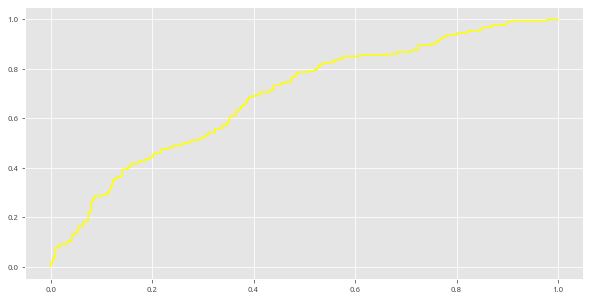

In [113]:
#Vejo a curva ROC do modelo INDIVIDUAL e confirmo o valor da AUC
from sklearn.metrics import (roc_curve,auc)

y_pred_prob1 = all_except_one_model.predict_proba(X_test_single_transformed)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test_single, y_pred_prob1)

auc_ind = auc(fpr1, tpr1)
print(auc_ind)
plt.plot(fpr1, tpr1, label= "Single Model - XGBoost - AUC " +  str(auc_ind), color="yellow")

In [114]:
y_pred_prob1.shape

(533,)

In [115]:
y_pred = all_except_one_model.predict(X_test_single_transformed)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

,,
,,
Ground Truth Prevalence,. . .,0.415
Test set Prevalence,. . .,0.161
True positive rate (recall),. . .,0.271
False positive rate,. . .,0.083
Positive predictive value (precision),. . .,0.698
True negative rate (specificity),. . .,0.917
False negative rate,. . .,0.729
Negative predictive value,. . .,0.640
Positive likelihood ratio (bigger is better),. . .,3.258


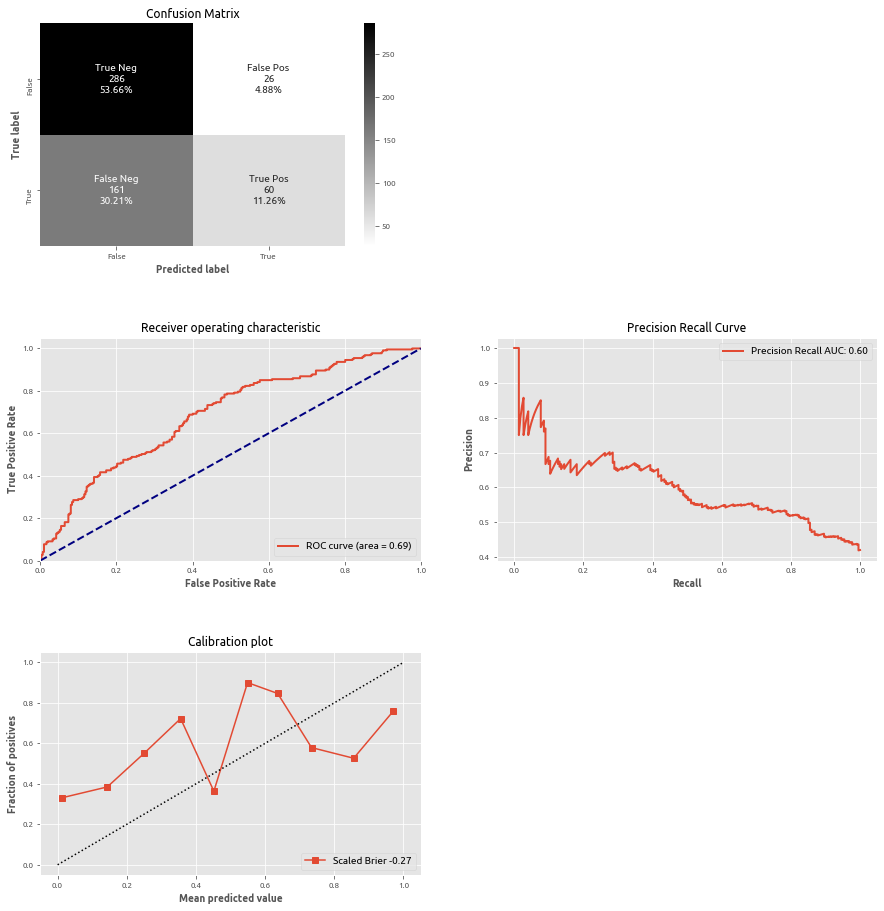

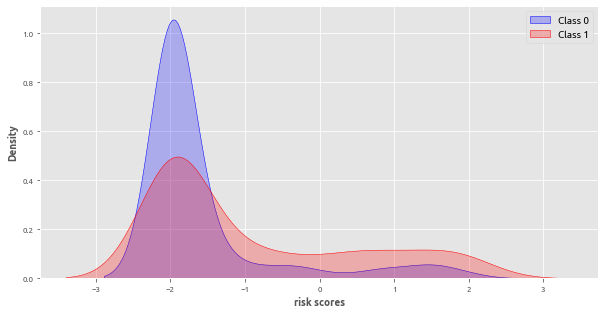

,,
,,
Ground Truth Prevalence,. . .,0.415
Test set Prevalence,. . .,0.161
True positive rate (recall),. . .,0.271
False positive rate,. . .,0.083
Positive predictive value (precision),. . .,0.698
True negative rate (specificity),. . .,0.917
False negative rate,. . .,0.729
Negative predictive value,. . .,0.640
Positive likelihood ratio (bigger is better),. . .,3.258


In [116]:
import MLFlow_Utils
binary_classification_metrics(y_test_single, y_pred, y_pred_prob1)

In [117]:
fprate, tprate, thresholds = roc_curve(y_test_single, y_pred_prob1, pos_label=1)
auc(fprate, tprate)

0.6898059519665855

In [118]:
#ROC_AUC
["{0:0.2f}".format(i) for i in AUC_CI(y_test_single, y_pred_prob1)]

['0.64', '0.73']

In [119]:
#recall
tpr(y_test_single, y_pred)

0.27149321266968324

In [120]:
#specificidade
tnr(y_test_single, pd.Series(y_pred))

0.9166666666666666

In [121]:
#accuracy
accuracy(y_test_single, y_pred)

0.649155722326454

In [122]:
ppv(y_test_single, y_pred)

0.6976744186046512

In [123]:
npv(y_test_single, y_pred)

0.639821029082774

# End of File